In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

In [2]:



def generate_unique_connected_graphs(n):
    """Generate all connected graphs on n nodes up to isomorphism."""
    unique_graphs = []
    nodes = list(range(n))
    possible_edges = list(combinations(nodes, 2))

    for r in range(n - 1, len(possible_edges) + 1):
        for edges in combinations(possible_edges, r):
            G = nx.Graph()
            G.add_nodes_from(nodes)
            G.add_edges_from(edges)

            if nx.is_connected(G):
                if not any(nx.is_isomorphic(G, H) for H in unique_graphs):
                    unique_graphs.append(G)
    return unique_graphs


def get_adjacency_matrix(G):
    return nx.to_numpy_array(G)


def get_laplacian_matrix(G):
    A = get_adjacency_matrix(G)
    D = np.diag(np.sum(A, axis=1))
    return D - A


def graph_symmetry_info(G):
    """Compute the automorphism group size."""
    matcher = nx.algorithms.isomorphism.GraphMatcher(G, G)
    return len(list(matcher.isomorphisms_iter()))




def build_graph_data(graphs):
    """
    Build per-graph dictionaries, and rank them by symmetry (descending)
    """

    data_unsorted = []

    for G in graphs:
        A = get_adjacency_matrix(G)
        L = get_laplacian_matrix(G)

        eigs = np.linalg.eigvalsh(A)  
        sym = graph_symmetry_info(G)

        data_unsorted.append({
            "graph": G,
            "adjacency": A,
            "laplacian": L,
            "eigenvalues": eigs,
            "symmetry_count": sym
        })

    # ---------- SORT BY SYMMETRY DESC ----------
    sorted_data = sorted(data_unsorted,
                         key=lambda x: x["symmetry_count"],
                         reverse=True)

    # Assign graph_id = rank in sorted list
    for gid, ginfo in enumerate(sorted_data):
        ginfo["graph_id"] = gid

    return sorted_data


# =========================
# Draw graphs
# =========================

def plot_graphs_with_spectra(graph_data):
    """Draw graphs in their symmetry-ranked order."""
    num_graphs = len(graph_data)
    fig, axes = plt.subplots(num_graphs, 1, figsize=(6, num_graphs * 3))

    if num_graphs == 1:
        axes = [axes]

    for ax, ginfo in zip(axes, graph_data):
        G = ginfo["graph"]
        eigvals = ginfo["eigenvalues"]
        sym = ginfo["symmetry_count"]
        gid = ginfo["graph_id"]

        nx.draw(G, with_labels=True, ax=ax)
        ax.set_title(
            f"Graph ID {gid}:  "
            f"Symmetries = {sym}, Spectrum = {np.round(eigvals, 2)}"
        )

    plt.tight_layout()
    plt.show()


# =========================
# Colormap plotting
# =========================

def plot_eigenvalue_spectrum_colormap(graph_data, cmap_name='viridis'):
    """
    Build colormap using symmetry-ranked graph IDs.
    """
    num_graphs = len(graph_data)
    num_nodes = len(graph_data[0]["eigenvalues"])

    all_eigs = np.concatenate([
        np.abs(np.round(ginfo["eigenvalues"], 5)) for ginfo in graph_data])
    
    unique_vals = np.unique(all_eigs)

    norm = plt.Normalize(vmin=np.min(unique_vals), vmax=np.max(unique_vals))
    cmap = plt.get_cmap(cmap_name + "_r")

    fig, ax = plt.subplots(figsize=(num_nodes + 8, num_graphs * 0.6))

    # Eigenvalue tiles
    for row_idx, ginfo in enumerate(graph_data):
        eigs = np.abs(np.round(ginfo["eigenvalues"], 5))
        counts = Counter(eigs)
        y = num_graphs - row_idx - 1

        for col_idx, val in enumerate(eigs):
            color = 'lightgrey' if counts[val] == 1 else cmap(norm(val))
            ax.add_patch(plt.Rectangle(
                (col_idx, y), 1, 1,
                facecolor=color,
                edgecolor='black'
            ))

    # Labels
    for row_idx, ginfo in enumerate(graph_data):
        y = num_graphs - row_idx - 0.5
        sym = ginfo["symmetry_count"]
        gid = ginfo["graph_id"]
        eigs = np.round(ginfo["eigenvalues"], 2)
        eig_str = "[" + ", ".join(f"{v:.2f}" for v in eigs) + "]"

        ax.text(num_nodes + 0.3, y, f"ID {gid}", va='center')
        ax.text(num_nodes + 1.5, y, f"{sym}", va='center')
        ax.text(num_nodes + 2.5, y, eig_str, va='center',
                family='monospace')

    # Axes
    ax.set_xlim(0, num_nodes + 6)
    ax.set_ylim(0, num_graphs)
    ax.set_xticks(np.arange(num_nodes) + 0.5)
    ax.set_xticklabels([f"$\\lambda_{i+1}$" for i in range(num_nodes)])
    ax.set_xlabel("Eigenvalues")

    ax.set_yticks(np.arange(num_graphs) + 0.5)
    ax.set_yticklabels(
        [f"Graph ID {ginfo['graph_id']}" for ginfo in graph_data[::-1]]
    )

    ax.invert_yaxis()
    ax.tick_params(left=False, bottom=False)

    for spine in ax.spines.values():
        spine.set_visible(False)    #remove spine enclosing the plot

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Eigenvalue Magnitude")

    plt.title("Eigenvalue Spectrum")
    plt.tight_layout()
    plt.show()




In [3]:
N = 6
graphs = generate_unique_connected_graphs(N)
graph_data = build_graph_data(graphs)

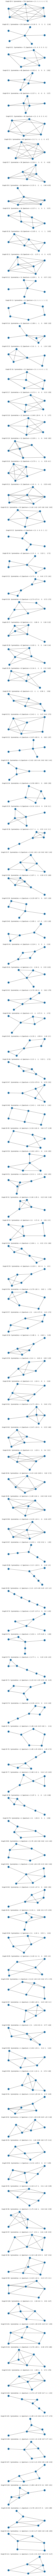

In [6]:

# Plot graphs
plot_graphs_with_spectra(graph_data)

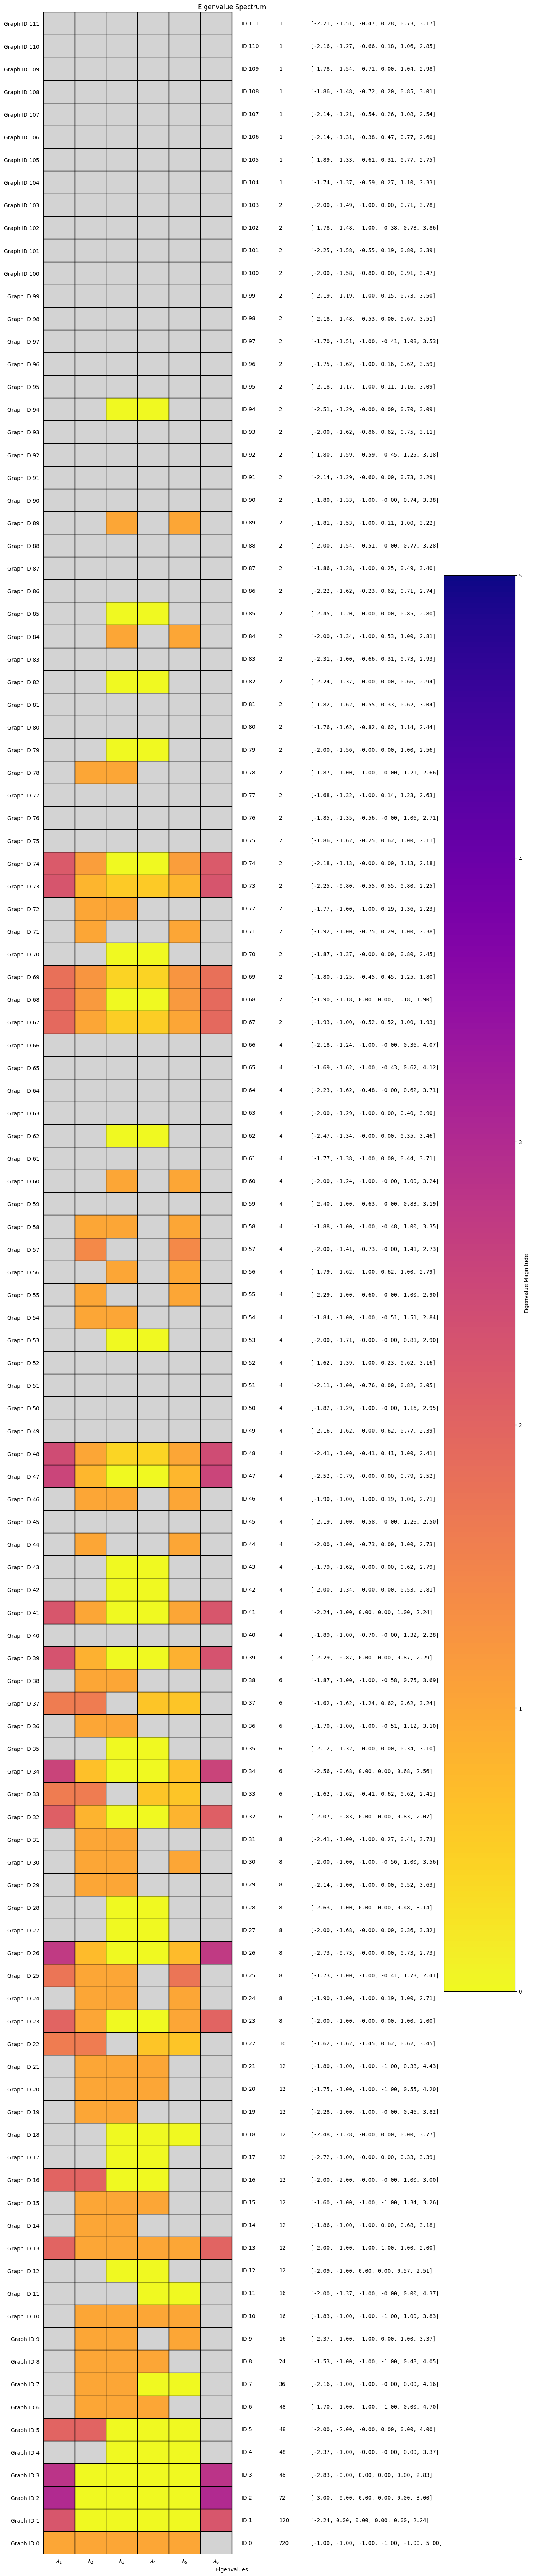

In [7]:
# Plot colormap
plot_eigenvalue_spectrum_colormap(graph_data, cmap_name='plasma')


In [ ]:
from networkx.algorithms import isomorphism as iso

def get_graph_by_id(graph_data, gid):
    """Return the graph info dict for a given graph_id."""
    for ginfo in graph_data:
        if ginfo["graph_id"] == gid:
            return ginfo
    raise ValueError(f"No graph with graph_id = {gid}")


def list_automorphisms_as_permutations(graph_data, gid):
    """
    Given a graph_id, return all automorphisms as permutations
    in one-line notation over the sorted node list.

    Returns:
        nodes: list of nodes (in the order used)
        perms: list of tuples, each a permutation (phi(n0), phi(n1), ..., phi(n_{N-1}))
    """
    ginfo = get_graph_by_id(graph_data, gid)
    G = ginfo["graph"]

    # Ensure a consistent node ordering
    nodes = sorted(G.nodes())

    matcher = iso.GraphMatcher(G, G)

    perms = []
    for phi in matcher.isomorphisms_iter():
        perm = tuple(phi[n] for n in nodes)
        perms.append(perm)

    return nodes, perms


In [21]:
gid = 32
nodes, perms = list_automorphisms_as_permutations(graph_data, gid)

print(f"Graph ID {gid} has {len(perms)} automorphisms.")
print("Nodes order:", nodes)
print(f"All automorphisms of Graph ID {gid} as permutations:")
for p in perms[:len(perms)]:
    print(p)


Graph ID 32 has 6 automorphisms.
Nodes order: [0, 1, 2, 3, 4, 5]
All automorphisms of Graph ID 32 as permutations:
(0, 1, 2, 3, 4, 5)
(0, 1, 2, 4, 3, 5)
(0, 1, 3, 2, 4, 5)
(0, 1, 4, 2, 3, 5)
(0, 1, 3, 4, 2, 5)
(0, 1, 4, 3, 2, 5)


In [30]:


def get_eigendecomposition_for_graph_id(graph_data, gid, decimals=2):
    """
    Compute eigenvalues/eigenvectors for the adjacency matrix
    """

    # Fetch graph info
    ginfo = next(d for d in graph_data if d["graph_id"] == gid)

    # Get adjacency
    A = ginfo["adjacency"]

    # Compute eigenvalues/vectors
    evals, evecs = np.linalg.eigh(A)

    # Rounded versions (for display)
    evals_round = np.round(evals, decimals)
    evecs_round = np.round(evecs, decimals)

    return  evals_round, evecs_round, A



In [34]:
gid = 91  
evals, evecs, A = get_eigendecomposition_for_graph_id(graph_data, gid)

print(f"Graph ID {gid}")
print("Eigenvalues:")
print(evals)

print("\nFirst eigenvector (corresponding to smallest eigenvalue):")
print(evecs[:, 0])

print("\nCheck A v = λ v for k = 2:")
k = 3
lam = evals[k]
v = evecs[:, k]
print("λ_k:", lam)
print("A v - λ v:", A @ v - lam * v)  # should be ~0 vector (up to numerical error)


Graph ID 91
Eigenvalues:
[-2.14 -1.29 -0.6   0.    0.73  3.29]

First eigenvector (corresponding to smallest eigenvalue):
[ 0.05 -0.57  0.45  0.45 -0.45  0.27]

Check A v = λ v for k = 2:
λ_k: 0.0
A v - λ v: [0. 0. 0. 0. 0. 0.]


In [28]:
L

array([[0., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 0.]])